<IPython.core.display.Javascript object>


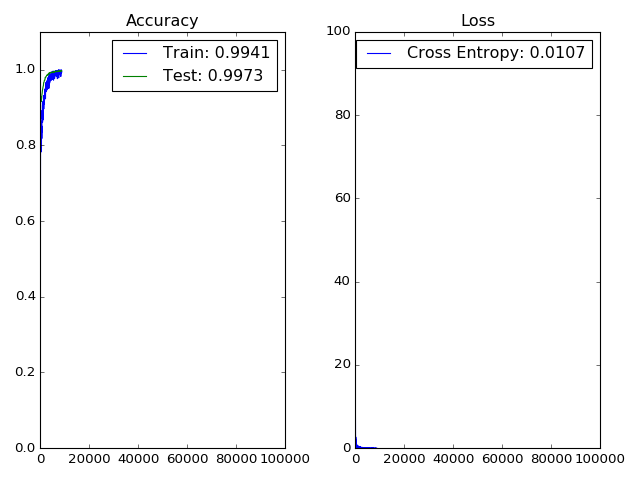

15471
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.113281
step 25, training accuracy 0.220703
step 50, training accuracy 0.429688
step 75, training accuracy 0.5625
step 99, test accuracy 0.891216
step 100, training accuracy 0.716797
step 125, training accuracy 0.806641
step 150, training accuracy 0.822266
step 175, training accuracy 0.832031
step 199, test accuracy 0.929416
step 200, training accuracy 0.865234
step 225, training accuracy 0.863281
step 250, training accuracy 0.865234
step 275, training accuracy 0.822266
step 299, test accuracy 0.922629
step 300, training accuracy 0.845703
step 325, training accuracy 0.833984
step 350, training accuracy 0.828125
step 375, training accuracy 0.835938
step 399, test accuracy 0.91623
step 400, training accuracy 0.826172
step 425, training

In [ ]:
from __future__ import print_function

%matplotlib notebook 

import tensorflow as tf
import numpy as np

from os.path import join
from helper_functions import *
from visualization import Visualization
from sklearn.model_selection import train_test_split

EPOCHS = 100000
LEARNING_RATE = 1e-4
BATCH_SIZE = 512

def weight_variable(shape):
    with tf.name_scope('weights'):
        initial = tf.truncated_normal(shape, stddev=0.1)
        weight = tf.Variable(initial)
        variable_summaries(weight)
        return weight

def bias_variable(shape):
    with tf.name_scope('biases'):
        initial = tf.constant(0.1, shape=shape)
        bias = tf.Variable(initial)
        variable_summaries(bias)
        return bias
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


class DigitClassifier():
    def __init__(self, data, filter_type='original'):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        viz = Visualization(epochs=EPOCHS)
        _x_data, _y_data = collect_images(data, filter_type)                
        target = np.zeros((len(_y_data), 10))
        target[np.arange(len(_y_data)),_y_data] = 1
        _y_data = target
        x_train, x_test, self.y_train, self.y_test = train_test_split(_x_data,_y_data,random_state=42)
        self._num_examples = len(x_train)
        print(len(x_train))
        
        # Flatten training images
        n_samples = len(x_train)
        self.x_train = x_train.reshape((n_samples,-1))
        n_samples = len(x_test)
        self.x_test = x_test.reshape((n_samples,-1))        
        
        # Get flattened test images
        self.test_images = self.get_test_images(self.x_test)    
        
        # Initialize input and target tensors
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
        
        # Initialize weight and bias tensors
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
        
        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)
            
        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
            
        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)
        
        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        
        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)
            
        with tf.name_scope('fully_connected_layer_1'):
            W_fc1 = weight_variable([7 * 7 * 64, 512])
            b_fc1 = bias_variable([512])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            tf.summary.scalar('dropout_keep_probability', keep_prob)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)        

        with tf.name_scope('fully_connected_layer_2'):
            W_fc2 = weight_variable([512, 10])
            b_fc2 = bias_variable([10])
            y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        with tf.name_scope('cross_entropy'):
            # The raw formulation of cross-entropy,
            #
            # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
            #                               reduction_indices=[1]))
            #
            # can be numerically unstable.
            #
            # So here we use tf.nn.softmax_cross_entropy_with_logits on the
            # raw outputs of the nn_layer above, and then average across
            # the batch.
            
            diff = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        tf.summary.scalar('cross_entropy', cross_entropy)

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
        sess = tf.Session()
        # Add an op to initialize the variables.
        init_op = tf.global_variables_initializer()

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        sess.run(init_op)
        
        # Merge all the summaries and write them out to /logs
        dir_path = os.path.abspath('')
        log_dir=join(dir_path,'logs-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '-' + str(LEARNING_RATE))        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(join(log_dir,'train'),
                                      sess.graph)
        test_writer = tf.summary.FileWriter(join(log_dir,'test'))
        
        for epoch in range(EPOCHS):
            batch = self.next_batch(BATCH_SIZE)    
            summary, _, acc, cross_entropy_loss = sess.run([merged, train_step, accuracy, cross_entropy], feed_dict={x : batch[0], y_ : batch[1], keep_prob: 0.5})
            
            if epoch % 100 == 99: # Record train set summaries, and test                
                run_metadata = tf.RunMetadata()
                train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)

                # Add training summary
                train_writer.add_summary(summary, epoch)
                                
                summary, test_accuracy, cross_entropy_loss = sess.run([merged, accuracy, cross_entropy], feed_dict={x : self.test_images, y_ : self.y_test, keep_prob: 1.0})
                print("step %d, test accuracy %g"%(epoch, test_accuracy))
                viz(epoch, test=test_accuracy, cross_entropy=cross_entropy_loss)
                test_writer.add_summary(summary, epoch)
            
            # Visualize training progress every 25 steps.
            if epoch % 25 == 0:                            
                print("step %d, training accuracy %g"%(epoch, acc))
                viz(epoch, train=acc, cross_entropy=cross_entropy_loss)
            
            if epoch % 2000 == 0:                
                # Save the variables to disk.
                save_path = saver.save(sess, "/tmp/" + str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + str(epoch) + "-" + "model.ckpt")
                
        print("Model saved in file: %s" % save_path)

        # Save the variables to disk.
        save_path = saver.save(sess, "/tmp/" + str(EPOCHS) + "-" + str(BATCH_SIZE) + \
                               "-" + str(LEARNING_RATE) + "-" + "model.ckpt")
        print("Model saved in file: %s" % save_path)
        self.sess = sess
                
        train_writer.close()
        test_writer.close()
            
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def __call__(self,feed_list=None, misclassified=False):        
        """ Classify images. """        
        if misclassified:
            # Get misclassified images.
            feed_list=[self.test_images,self.y_test,1.0]
        x, y_, keep_prob = self.get_placeholders()
        feed_dict = {x : feed_list[0], y_: feed_list[1], keep_prob:feed_list[2]}
        sess = tf.get_default_session()
        classification, accuracy = sess.run([y_conv, accuracy], feed_dict)
        print("classification %g"%classification)
        print("test accuracy %g"%accuracy)

    def get_placeholders(self):
        x = tf.get_default_graph().get_tensor_by_name("x-input")
        y = tf.get_default_graph().get_tensor_by_name("y-input")
        keep_prob = tf.get_default_graph().get_tensor_by_name("keep-prob")
        return x, y, keep_prob
    
    def get_test_images(self, x_test):
        """Return flattened images. """
        n_samples = len(x_test)
        return x_test.reshape((n_samples, -1))


# Load dataset.
data = pickle.load(open('data3_4.p', 'rb'))

digit_classifier = DigitClassifier(data, 'original')

In [ ]:
# Check individual image classification

fig = plt.figure()
def check_image(i):
    image = data['original'][i].reshape((-1,784))
    target_number = data['targets'][i]
    target = np.zeros((1, 10))
    target[np.arange(1),target_number] = 1    
    print(target,target_number)
    feed_list = [image, target, 1.0]
    number_data(feed_list)
    plt.imshow(image.reshape((28,28)),cmap=plt.cm.gray)
    plt.show()

# check_image(0)



In [ ]:
digit_classifier(misclassified=True)